# ELMo Contextual Embeddings

In this notebook, we use contextual embeddings from ELMo to study semantic change of conversion.

In [1]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import allennlp.commands.elmo
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.decomposition
import sklearn.metrics
import tqdm
import random

import src.corpus

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Parse the corpus

In [2]:
#UD_FILE = "../data/en_ewt-ud-train.conllu"
#corpus = src.corpus.POSCorpus.create_from_ud(data_file_path=UD_FILE)

BNC_FILE = "../data/bnc/bnc.pkl"
corpus = src.corpus.POSCorpus.create_from_bnc_pickled(data_file_path=BNC_FILE)

## Run ELMo on random part of the corpus

In [3]:
# Take only 1M words out of 4M to make it run faster
SAMPLE_PROPORTION = 0.25
random.seed(12345)
random_indices = random.sample(range(len(corpus.sentences)), int(SAMPLE_PROPORTION * len(corpus.sentences)))

sampled_sentences = []
for ix in random_indices:
  sampled_sentences.append(corpus.sentences[ix])

In [4]:
elmo = allennlp.commands.elmo.ElmoEmbedder(cuda_device=0)
data_as_tokens = [[t['word'] for t in sentence] for sentence in sampled_sentences]

BATCH_SIZE = 64
elmo_embeddings = []
for ix in tqdm.tqdm(range(0, len(data_as_tokens), BATCH_SIZE)):
  batch = data_as_tokens[ix : ix+BATCH_SIZE]
  batch_embeddings = elmo.embed_batch(batch)
  # Only take embeddings from last ELMo layer
  batch_embeddings = [x[-1] for x in batch_embeddings]
  elmo_embeddings.extend(batch_embeddings)

100%|██████████| 1098/1098 [03:00<00:00,  6.07it/s]


## ELMo embeddings of instances of a fixed lemma

In [9]:
def get_elmo_embeddings_for_lemma(lemma):
  noun_embeddings = []
  verb_embeddings = []

  for sentence_ix in range(len(sampled_sentences)):
    token_list = sampled_sentences[sentence_ix]
    embeddings = elmo_embeddings[sentence_ix]
    for i in range(len(token_list)):
      if token_list[i]['lemma'] == lemma:
        if token_list[i]['pos'] == 'NOUN':
          noun_embeddings.append(embeddings[i])
        elif token_list[i]['pos'] == 'VERB':
          verb_embeddings.append(embeddings[i])

  noun_embeddings = np.vstack(noun_embeddings)
  verb_embeddings = np.vstack(verb_embeddings)
  return noun_embeddings, verb_embeddings

In [54]:
FIXED_LEMMA = "use"
noun_embeddings, verb_embeddings = get_elmo_embeddings_for_lemma(FIXED_LEMMA)
print("Noun instances:", noun_embeddings.shape[0])
print("Verb instances:", verb_embeddings.shape[0])

Noun instances: 197
Verb instances: 703


## Apply PCA and plot

In [55]:
pca = sklearn.decomposition.PCA(n_components=2)
all_embeddings = pca.fit_transform(np.vstack([noun_embeddings, verb_embeddings]))
all_embeddings_df = pd.DataFrame({'x0': all_embeddings[:,0], 'x1': all_embeddings[:,1]})
all_embeddings_df['pos'] = ['noun'] * len(noun_embeddings) + ['verb'] * len(verb_embeddings)

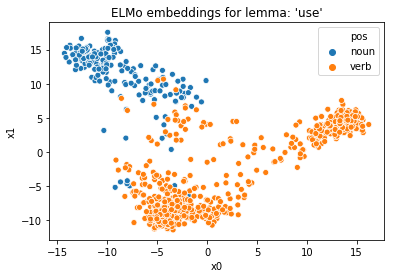

In [56]:
plot = sns.scatterplot(data=all_embeddings_df, x='x0', y='x1', hue='pos')
plot.set(title="ELMo embeddings for lemma: '%s'" % FIXED_LEMMA)
plt.show()

## Utility to inspect what ELMo is capturing

In [64]:
num_printed = 0
for sentence_ix in range(len(sampled_sentences)):
  token_list = sampled_sentences[sentence_ix]
  embeddings = elmo_embeddings[sentence_ix]
  for i in range(len(token_list)):
    if token_list[i]['lemma'] == FIXED_LEMMA:
      v = pca.transform(embeddings[i][np.newaxis, :])[0]
      if v[1] < -10: # <- Put whatever condition here
        print(v)
        print(' '.join([t['word'] for t in token_list]))
        print()
        num_printed += 1
  if num_printed > 10:
    break

[ -5.7458987 -10.616318 ]
The second problem involving tense relates to whether you should use the present or the past tense in your writing .

[ -4.0321655 -10.276349 ]
To use his own language :

[ -4.6986246 -10.787599 ]
Using our discussion of essay types above ( pp. 53 – 7 ) , decide which of the following types your essay is : DESCRIPTIVE If so , how is it organised : line by line ? thematically ? etc .

[ -4.9001822 -10.372129 ]
or you can use it as a tie round mhm , what about having , that 's a bit harder

[ -4.161479 -10.403955]
They use potassium cyanide commercially .

[ -3.1759417 -10.488535 ]
A particularly severe test is to use the results to estimate the population of the area over the kilometre square grid given by the UK Ordnance Survey .

[ -4.4409485 -10.486507 ]
Excuse me just because the tape 's on there 's no need for you to use big words like prognosis .

[ -3.9161649 -11.317919 ]
Using the same information available for a sequential description , however , it is

## Cosine similarity between noun and verb usages

In [13]:
lemma_count_df = corpus.get_per_lemma_stats()

# Filter: must have at least [x] noun and [x] verb usages
lemma_count_df = lemma_count_df[(lemma_count_df['noun_count'] >= 100) & (lemma_count_df['verb_count'] >= 100)]
lemma_count_df = lemma_count_df.sort_values('total_count', ascending=False)
print('Remaining lemmas:', len(lemma_count_df))

Remaining lemmas: 112


In [14]:
def get_nv_cosine_similarity(row):
  noun_embeddings, verb_embeddings = get_elmo_embeddings_for_lemma(row.lemma)
  
  avg_noun_embedding = np.mean(noun_embeddings, axis=0)
  avg_verb_embedding = np.mean(verb_embeddings, axis=0)

  return float(sklearn.metrics.pairwise.cosine_similarity(avg_noun_embedding[np.newaxis,:], avg_verb_embedding[np.newaxis,:]))

lemma_count_df['nv_cosine_similarity'] = lemma_count_df.apply(get_nv_cosine_similarity, axis=1)

In [15]:
lemma_count_df[['lemma', 'noun_count', 'verb_count', 'majority_tag', 'nv_cosine_similarity']] \
  .sort_values('nv_cosine_similarity').head(8)

,lemma,noun_count,verb_count,majority_tag,nv_cosine_similarity
1258,base,109,378,VERB,0.306704
550,press,130,189,VERB,0.324000
1216,wave,402,135,NOUN,0.328990
1071,miss,320,420,VERB,0.351794
236,force,472,195,NOUN,0.351958
730,hand,1881,136,NOUN,0.446096
2942,aim,137,101,NOUN,0.447685
528,lead,109,743,VERB,0.448039


In [16]:
lemma_count_df[['lemma', 'noun_count', 'verb_count', 'majority_tag', 'nv_cosine_similarity']] \
  .sort_values('nv_cosine_similarity', ascending=False).head(8)

,lemma,noun_count,verb_count,majority_tag,nv_cosine_similarity
2554,sleep,179,298,VERB,0.872245
10,matter,586,296,NOUN,0.850081
194,mind,740,621,NOUN,0.840517
149,go,294,13947,VERB,0.836878
724,fear,217,104,NOUN,0.830816
2454,drink,460,325,NOUN,0.819494
969,doubt,261,135,NOUN,0.806345
3374,walk,152,958,VERB,0.802643


/scratch/gobi1/wgao/anaconda-pkgs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


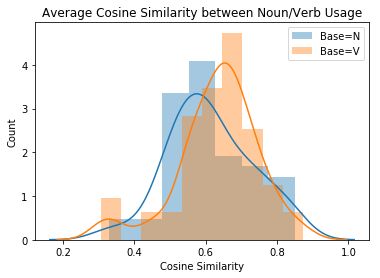

In [17]:
plot = sns.distplot(lemma_count_df[lemma_count_df.majority_tag == 'NOUN'].nv_cosine_similarity, label='Base=N')
plot = sns.distplot(lemma_count_df[lemma_count_df.majority_tag == 'VERB'].nv_cosine_similarity, label='Base=V')
plt.legend()
plot.set(title="Average Cosine Similarity between Noun/Verb Usage",
         xlabel="Cosine Similarity", ylabel="Count")
plt.show()

In [18]:
# T-test of difference in mean
import scipy.stats
scipy.stats.ttest_ind(lemma_count_df[lemma_count_df.majority_tag == 'NOUN'].nv_cosine_similarity,
                      lemma_count_df[lemma_count_df.majority_tag == 'VERB'].nv_cosine_similarity)

Ttest_indResult(statistic=-0.9751445184187677, pvalue=0.3316281818266853)